# Imports

In [ ]:
#!pip install -r requirements.txt
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [ ]:
from google.cloud import bigquery
import json
import ast

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

In [ ]:
#Connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

# Load Data 

In [ ]:
# LOAD DATA
df = pd.read_csv('')
print(df.shape[0])
df = df[df['Childs_Age']<=19]
df['Net_Pay'] = df['Net_Pay'].astype(int)
df = df[df['Net_Pay']>0]
print(df.shape[0])

df['Childs_Age'] = df['Childs_Age'].astype(int)
df['PaidTransaction_Date'] = pd.to_datetime(df['PaidTransaction_Date'])
df['Serv_Week'] = pd.to_datetime(df['Serv_Week'])

3360229
2890982


# Latency

In [ ]:
df['Serv_Week'] = pd.to_datetime(df['Serv_Week'])
df['PaidTransaction_Date'] =  pd.to_datetime(df['PaidTransaction_Date'])
df['Latency'] = df['PaidTransaction_Date'] - df['Serv_Week']
df['Latency'] = df['Latency'].dt.days

# Days Diff1

In [ ]:
df['Child_Begin_Care'] = pd.to_datetime(df['Child_Begin_Care'])
df['Days_diff_1'] = df['Serv_Week'] - df['Child_Begin_Care']
df['Days_diff_1'] = df['Days_diff_1'].dt.days

# Net_Gross_Diff

In [ ]:
df['Net_Gross_Diff'] = df['Net_Pay']- df['Gross_Paid']
df['Net_Gross_Diff'] = df['Net_Gross_Diff'].replace(np.nan, 0)

# Case and Child _nunique

In [ ]:
childcase = df.groupby(['Provider_ID', 'Serv_Week']).rolling(10000, on='PaidTransaction_Date')['Child_PK', 'Case'].count().astype(int).reset_index()
provchild = childcase.groupby(['Provider_ID', 'Serv_Week', 'PaidTransaction_Date']).agg({'Child_PK':'max', 'Case': 'max'}).rename(columns={'Child_PK':'max_child', 'Case': 'max_case'}).reset_index()
groupbydf = pd.DataFrame()
prov = provchild['Provider_ID'].unique()
for i in prov:
    diffchange = provchild.loc[provchild['Provider_ID']==i]
    diffchange.max_case = diffchange['max_case'].diff()
    diffchange.max_child = diffchange['max_child'].diff()
    groupbydf = groupbydf.append(diffchange, ignore_index=True)
groupbydf = groupbydf.rename(columns={'max_child': 'Child_PK_nunique', 'max_case':'Case_nunique'})
df = df.merge(groupbydf, on=['Provider_ID', 'Serv_Week', 'PaidTransaction_Date'])
df.head(1)
print(df.shape)

(2890982, 60)


# FT_Rate_diff

In [ ]:
df['FT_Rate_diff'] = df['ProvFTRate'] - df['StateFTRate']
df['FT_Rate_diff'] = df['FT_Rate_diff'].replace(np.nan, 0)

# BA_Rate_diff

In [ ]:
df['BA_Rate_diff'] = df['ProvBARate'] - df['StateBARate']
df['BA_Rate_diff'] = df['BA_Rate_diff'].replace(np.nan, 0)

# Number of UAS Codes associated with a provider (n_UAS)

In [ ]:
uascount = df.groupby(['Provider_ID', 'Serv_Week']).rolling(10000, on='PaidTransaction_Date')['UAS'].count().astype(int).rename('CountUAS').reset_index()
uasmax = uascount.groupby(['Provider_ID', 'Serv_Week', 'PaidTransaction_Date']).agg({'CountUAS':'max'}).rename(columns={'CountUAS':'max_uas'}).reset_index()
df = df.merge(uasmax,on=['Provider_ID', 'Serv_Week', 'PaidTransaction_Date'])
print(df.shape)

(2890982, 63)


# Max Child Age, Min Child Age wrt UAS (Max_Child_Age_UAS, Min_Child_Age_UAS)

In [ ]:
childage = df.groupby(['Provider_ID','Serv_Week','UAS','PaidTransaction_Date']).agg({'Childs_Age':['max','min']}).reset_index()
childage.columns = list(map(''.join, childage.columns.values))
childmaxmin = childage.groupby(['Serv_Week','Provider_ID','PaidTransaction_Date','UAS']).agg({'Childs_Agemax':'max','Childs_Agemin':'min'}).reset_index()
childmaxmin = childmaxmin.rename(columns={'Childs_Agemax':'Max_Child_Age_UAS', 'Childs_Agemin': 'Min_Child_Age_UAS'})
df = df.merge(childmaxmin,on=['Serv_Week','Provider_ID', 'PaidTransaction_Date', 'UAS'])


In [ ]:
df.shape

(2890982, 65)

# Number of Children Associated with each UAS Code: 

In [ ]:
uascount = (df.groupby(['Provider_ID', 'Serv_Week','UAS']).rolling(10000, on='PaidTransaction_Date')['Child_PK'].count().astype(int).rename('CountChild').reset_index())
maxuas = uascount.groupby(['Serv_Week','Provider_ID','PaidTransaction_Date','UAS']).agg({'CountChild':'max'}).rename(columns={'CountChild':'max_count_child_uas'}).reset_index()
df = df.merge(maxuas,on=['Serv_Week','Provider_ID','PaidTransaction_Date','UAS'])
df.shape


(2890982, 66)

# How many TOCs are associated with the child and the Provider

In [ ]:
tocchild = (df.groupby(['Provider_ID', 'TOC', 'Serv_Week']).rolling(10000, on='PaidTransaction_Date')['Child_PK'].count().astype(int).rename('CountChildPK').reset_index())
tocchildmax = tocchild.groupby(['Provider_ID', 'TOC','Serv_Week', 'PaidTransaction_Date']).agg({'CountChildPK':'max'}).rename(columns={'CountChildPK':'max_child_toc'}).reset_index()
df = df.merge(tocchildmax,on=['Provider_ID','TOC', 'Serv_Week', 'PaidTransaction_Date'])
df.shape

(2890982, 67)

# How many TOCs are associated with the child.


In [ ]:
toccount = (df.groupby(['Child_PK', 'Serv_Week']).rolling(5000, on='PaidTransaction_Date')['TOC'].count().astype(int).rename('Count_TOC').reset_index())
tocmax = toccount.groupby(['Serv_Week','Child_PK','PaidTransaction_Date']).agg({'Count_TOC':'max'}).rename(columns={'Count_TOC':'max_count_toc'}).reset_index()
df = df.merge(tocmax,on=['Serv_Week','Child_PK','PaidTransaction_Date'])
df.shape


(2890982, 68)

# Difference between the  License Capacity of the Provider and the Actual Capacity (assuming capacity is inclusive of all the tocs, the license capacity is of the same period as the prfCombined)

In [ ]:
capacity = pd.read_csv('')
capacity = capacity[['Provider_Number','License_Capacity']]

capacity = capacity.rename(columns={'Provider_Number':'Provider_License'})
df = df.merge(capacity,on=['Provider_License'])

# d = df.groupby(['Provider_ID']).agg({'Child_PK':'nunique'}).reset_index()
# d = d.rename(columns={'Child_PK':'Capacity_from_prf'})

# df = df.merge(d,on=['Provider_ID'])
# df['Difference_Capacity'] = df['License_Capacity'] - df['Capacity_from_prf']
# #df.drop(['License_Capacity','License_Capacity'], axis=1)
# df.columns

In [ ]:
childcount = (df.groupby(['Provider_ID', 'Serv_Week']).rolling(5000, on='PaidTransaction_Date')['Child_PK'].count().astype(int).rename('CountChild').reset_index())
childmax = childcount.groupby(['Serv_Week','Provider_ID','PaidTransaction_Date']).agg({'CountChild':'max'}).rename(columns={'CountChild':'max_count_child_capacity'}).reset_index()
df = df.merge(childmax,on=['Serv_Week','Provider_ID','PaidTransaction_Date'])
df['Difference_Capacity']=df['License_Capacity']-df['max_count_child_capacity']
df = df.drop('max_count_child_capacity', axis=1)
df.shape

(2807662, 70)

# All Rules

Taking union of all the rules as a binary column

In [ ]:
cols = ['DifferentProviders', 'SameProviders', 'RegistrationFees', 'overlapPreK', 'LargeBilling', 'ChildrenOverCapacity', 'PaymentLatency', 'FamilyUnit', 'CostPerChild']


In [ ]:
df["AllRules"] = np.where(df[cols].any(axis=1), 1, 0)

In [ ]:
df.columns

Index(['Case', 'Child', 'Cert', 'UAS', 'Serv_Week', 'PaidTransaction_Date',
       'Childs_Age', 'Provider_Name', 'Provider_ID', 'Provider_License',
       'Provider_Address', 'Provider_City_State_Zip_Code', 'Region',
       'Provider_County_Code', 'CAPS_Zone', 'QR_Star', 'Tier', 'TOP', 'TOC',
       'VSS', 'FTWeek', 'Y', 'StateFTRate', 'ProvFTRate', 'StateBARate',
       'ProvBARate', 'P', 'StatePTRate', 'ProvPTRate', 'Gross_Paid', 'Adjust',
       'Reg_Fee', 'Tier_bonus', 'Child_Fee', 'Net_Pay', 'E3ZUAS_630_Amount',
       'Invoice', 'Provd_Chg', 'Provd_Diff', 'Neg_Rate', 'Child_Begin_Care',
       'Post_111', 'fileId', 'incrementalId', 'Child_PK', 'Latency',
       'ServWeekYear', 'DifferentProviders', 'SameProviders',
       'RegistrationFees', 'overlapPreK', 'LargeBilling',
       'ChildrenOverCapacity', 'PaymentLatency', 'FamilyUnit', 'CostPerChild',
       'Days_diff_1', 'Net_Gross_Diff', 'Child_PK_nunique', 'Case_nunique',
       'FT_Rate_diff', 'BA_Rate_diff', 'max_uas', 'Max_

Creating a subset dataframe to find the correlation between the features created with all the rules

In [ ]:
corrdf = df[['AllRules', 'Latency', 'Days_diff_1', 'Net_Gross_Diff', 'Child_PK_nunique', 'Case_nunique',
       'FT_Rate_diff', 'BA_Rate_diff', 'Provd_Diff', 'max_uas', 'Max_Child_Age_UAS',
       'Min_Child_Age_UAS', 'max_count_child_uas', 'max_child_toc',
       'max_count_toc', 'License_Capacity', 'Difference_Capacity','DifferentProviders', 'SameProviders',
       'RegistrationFees', 'overlapPreK', 'LargeBilling',
       'ChildrenOverCapacity', 'PaymentLatency', 'FamilyUnit', 'CostPerChild']]

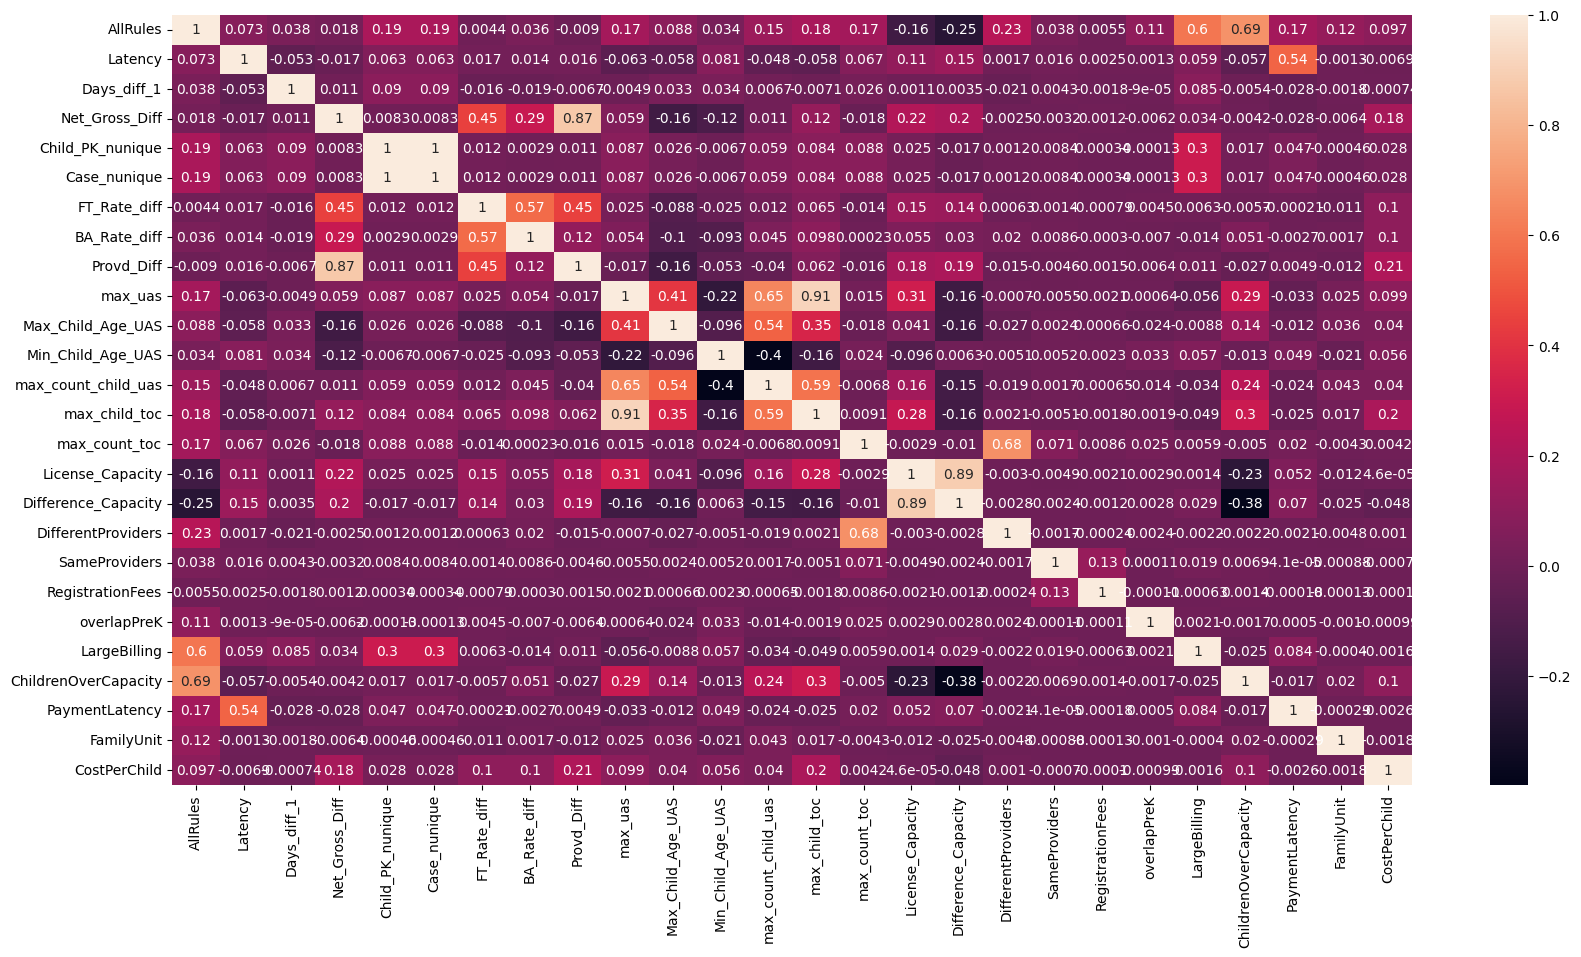

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(corrdf.corr(method = 'pearson'), annot=True)
plt.show()

AllRules is correlated with Child_PK_nunique, max_uas, max_count_child, max_count_toc, License_Capacity and Difference_Capacity
DifferentProviders - highly correlated with max_count_toc
SameProviders - 
RegistrationFees - 
overlapPreK - 
LargeBilling correlated with Child_PK_nunique
ChildrenOverCapacity correlated with max_uas, Max_Child_Age_UAS, max_count_child_uas, License_Capacity and Difference_Capacity
PaymentLatency is correlated with Latency
FamilyUnit - 
CostPerChild is correlated with Net_Gross_Diff, FT_Rate_diff, BA_Rate_Diff, Provd_Diff, ,max_child_toc

# Model 

## Taking into account the new features that were created

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

In [ ]:
#Set of independent variables
X = df[['Latency', 'Days_diff_1', 'Net_Gross_Diff', 'Child_PK_nunique', 'Case_nunique',
       'FT_Rate_diff', 'BA_Rate_diff', 'Provd_Diff', 'max_uas', 'Max_Child_Age_UAS',
       'Min_Child_Age_UAS', 'max_count_child_uas', 'max_child_toc',
       'max_count_toc', 'License_Capacity', 'Difference_Capacity']]

In [ ]:
#Dependent variable
y = df["AllRules"]

In [ ]:
#Training and Testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2246129, 16) (561533, 16) (2246129,) (561533,)


In [ ]:
from xgboost import XGBClassifier

In [ ]:
#Creating xgb classifier
xgb_clf = XGBClassifier()

#Fitting the model
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
#Predicting X_test
xgbprediction = xgb_clf.predict(X_test)

Checking feature importance

In [ ]:
feature_important = xgb_clf.get_booster().get_score(importance_type='weight')
feature_important_sort = dict(sorted(feature_important.items(), key=lambda x:-1*x[1]))
feature_important_sort

{'Child_PK_nunique': 711.0,
 'max_uas': 698.0,
 'Difference_Capacity': 575.0,
 'License_Capacity': 505.0,
 'max_child_toc': 352.0,
 'Net_Gross_Diff': 329.0,
 'Latency': 299.0,
 'Days_diff_1': 299.0,
 'Provd_Diff': 256.0,
 'BA_Rate_diff': 250.0,
 'max_count_child_uas': 197.0,
 'FT_Rate_diff': 194.0,
 'Max_Child_Age_UAS': 141.0,
 'max_count_toc': 123.0,
 'Min_Child_Age_UAS': 116.0}

In [ ]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import classification_report

In [ ]:
classification_report_oversample = classification_report(y_test, xgbprediction)
print(classification_report_oversample)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    471182
           1       0.95      0.72      0.82     90351

    accuracy                           0.95    561533
   macro avg       0.95      0.86      0.89    561533
weighted avg       0.95      0.95      0.95    561533



In [ ]:
cm= confusion_matrix(y_test, xgbprediction)  
cm

array([[467560,   3622],
       [ 25373,  64978]])

Displaying the confusion matrix

[[467560   3622]
 [ 25373  64978]]


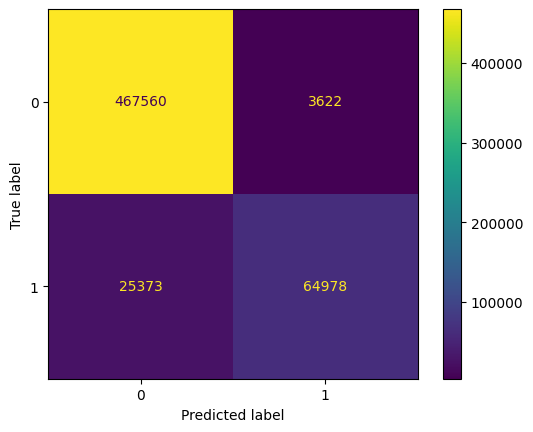

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, xgbprediction, labels=xgb_clf.classes_)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
disp.plot()
plt.show()

Getting false positive rows

In [ ]:
X_test[(y_test == 0) & (xgbprediction == 1)]

,Latency,Days_diff_1,Net_Gross_Diff,Child_PK_nunique,Case_nunique,FT_Rate_diff,BA_Rate_diff,Provd_Diff,max_uas,Max_Child_Age_UAS,Min_Child_Age_UAS,max_count_child_uas,max_child_toc,max_count_toc,License_Capacity,Difference_Capacity
2738832,15,118.0,42.0,4.0,4.0,46.0,11.0,0.0,16,9,4,2,10,1,137,121
1470573,8,242.0,26.0,0.0,0.0,0.0,0.0,NaN,53,8,1,10,24,2,84,31
752518,8,96.0,47.0,2.0,2.0,0.0,0.0,16.0,48,10,0,16,27,2,99,51
2107265,15,51.0,90.0,9.0,9.0,50.0,27.0,58.0,16,11,2,9,12,1,114,98
336818,8,1260.0,104.0,-2.0,-2.0,0.0,0.0,NaN,37,13,2,28,23,1,105,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2588157,64,38.0,64.0,3.0,3.0,20.0,45.0,20.0,101,12,0,38,42,2,258,157
1890024,8,235.0,134.0,6.0,6.0,13.0,79.0,13.0,31,9,1,14,15,1,52,21
2171712,8,1218.0,105.0,-2.0,-2.0,0.0,0.0,NaN,12,12,3,5,9,1,84,72
410296,8,10.0,27.0,0.0,0.0,-7.0,43.0,0.0,98,12,2,5,49,1,99,1


# With all attributes

## Data Preparation 

In [ ]:
df.isnull().sum()

Case                                  0
Child                                 0
Cert                                  0
UAS                                   0
Serv_Week                             0
PaidTransaction_Date                  0
Childs_Age                            0
Provider_Name                         0
Provider_ID                           0
Provider_License                      0
Provider_Address                      0
Provider_City_State_Zip_Code          0
Region                                0
Provider_County_Code                  0
CAPS_Zone                             0
QR_Star                           81202
Tier                                  0
TOP                                   0
TOC                                   0
VSS                             1443322
FTWeek                          1443322
Y                               1443322
StateFTRate                     1443322
ProvFTRate                      1443322
StateBARate                     1443322


Creating Age Bins

In [ ]:
bins = [-1, 0, 1, 2, 5, 23]
labels = ['Zero', '0 to 1', '1 to 2', '3 to 5', 'Above 6']
df['binned'] = pd.cut(df['Childs_Age'], bins, labels=labels)

In [ ]:
df['binned'].value_counts()

3 to 5     1041981
Above 6    1011251
1 to 2      354615
0 to 1      273974
Zero        125841
Name: binned, dtype: int64

One hot encoding on Region, TOP, TOC, VSS and Age bins

In [ ]:
one_hot_encoded_data = pd.get_dummies(df, columns = ['Region', 'TOP', 'TOC', 'VSS', 'binned'])

Label Encoding for UAS

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
cols = ['UAS']
#
# Encode labels of multiple columns at once
#
one_hot_encoded_data[cols] = one_hot_encoded_data[cols].apply(LabelEncoder().fit_transform)
one_hot_encoded_data

,Case,Child,Cert,UAS,Serv_Week,PaidTransaction_Date,Childs_Age,Provider_Name,Provider_ID,Provider_License,Provider_Address,Provider_City_State_Zip_Code,Provider_County_Code,CAPS_Zone,QR_Star,Tier,FTWeek,Y,StateFTRate,ProvFTRate,StateBARate,ProvBARate,P,StatePTRate,ProvPTRate,Gross_Paid,Adjust,Reg_Fee,Tier_bonus,Child_Fee,Net_Pay,E3ZUAS_630_Amount,Invoice,Provd_Chg,Provd_Diff,Neg_Rate,Child_Begin_Care,Post_111,fileId,incrementalId,Child_PK,Latency,ServWeekYear,DifferentProviders,SameProviders,RegistrationFees,overlapPreK,LargeBilling,ChildrenOverCapacity,PaymentLatency,FamilyUnit,CostPerChild,Days_diff_1,Net_Gross_Diff,Child_PK_nunique,Case_nunique,FT_Rate_diff,BA_Rate_diff,max_uas,Max_Child_Age_UAS,Min_Child_Age_UAS,max_count_child_uas,max_child_toc,max_count_toc,License_Capacity,Difference_Capacity,AllRules,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,Region_10,Region_11,Region_12,Region_14,TOP_Center,TOP_Family Home,TOC_Before & After School,TOC_Day Care,TOC_Night,TOC_Part Time,VSS_N,VSS_Y,binned_Zero,binned_0 to 1,binned_1 to 2,binned_3 to 5,binned_Above 6
0,123412964,1,5689330,16,2021-05-24,2022-01-04,0,"CAMPBELL, PAMELA F",52902,FR-18026,709 DEERING ROAD,"CONYERS, GA 30094-",122.0,1,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,70.0,0.0,7.0,NaN,77,NaN,3545843.0,125.0,125.0,125.0,2020-11-02,NaN,20220104,0,123412964_1,225,2021,0,0,0,0,0,0,1,0,0,203.0,77.0,NaN,NaN,0.0,0.0,1,0,0,1,1,1,6,5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
1,123412964,1,5689330,16,2021-05-31,2022-01-04,0,"CAMPBELL, PAMELA F",52902,FR-18026,709 DEERING ROAD,"CONYERS, GA 30094-",122.0,1,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,70.0,0.0,7.0,NaN,77,NaN,3545843.0,125.0,125.0,125.0,2020-11-02,NaN,20220104,6,123412964_1,218,2021,0,0,0,0,0,0,1,0,0,210.0,77.0,0.0,0.0,0.0,0.0,1,0,0,1,1,1,6,5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
2,123412964,1,5689330,16,2021-06-07,2022-01-04,0,"CAMPBELL, PAMELA F",52902,FR-18026,709 DEERING ROAD,"CONYERS, GA 30094-",122.0,1,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,70.0,0.0,7.0,NaN,77,NaN,3545844.0,125.0,125.0,125.0,2020-11-02,NaN,20220104,13,123412964_1,211,2021,0,0,0,0,0,0,1,0,0,217.0,77.0,0.0,0.0,0.0,0.0,1,0,0,1,1,1,6,5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
3,123412964,1,5689330,16,2021-06-14,2022-01-04,0,"CAMPBELL, PAMELA F",52902,FR-18026,709 DEERING ROAD,"CONYERS, GA 30094-",122.0,1,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,70.0,0.0,7.0,NaN,77,NaN,3545844.0,125.0,125.0,125.0,2020-11-02,NaN,20220104,20,123412964_1,204,2021,0,0,0,0,0,0,1,0,0,224.0,77.0,0.0,0.0,0.0,0.0,1,0,0,1,1,1,6,5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
4,123412964,1,5689330,16,2021-06-21,2022-01-04,0,"CAMPBELL, PAMELA F",52902,FR-18026,709 DEERING ROAD,"CONYERS, GA 30094-",122.0,1,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,70.0,0.0,7.0,NaN,77,NaN,3545844.0,125.0,125.0,125.0,2020-11-02,NaN,20220104,27,123412964_1,197,2021,0,0,0,0,0,0,1,0,0,231.0,77.0,0.0,0.0,0.0,0.0,1,0,0,1,1,1,6,5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2807657,126872047,1,6616247,16,2022-10-31,2022-12-27,12,ICARE @ TOCCOA,142846,CCLC-57828,1760 W. CURRAHEE STREET,"TOCCOA, GA 30577-",127.0,3,1.0,0,N,4.0,85.0,465.0,50.0,325.0,0.0,24.0,100.0,325.0,0.0,65.0,0.0,0.0,390,NaN,13548135.0,325.0,0.0,325.0,2022-07-13,X,20221227,3291035,126872047_1,57,2022,0,0,0,0,0,0,0,0,1,110.0,65.0,NaN,NaN,380.0,275.0,36,12,4,6,20,1,108,72,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1
2807658,122379026,1,6616244,16,2022-10-31,2022-12-27,5,ICARE @ TOCCOA,142846,CCLC-57828,1760 W. CURRAHEE STREET,"TOCCOA, GA 30577-"

Filtering the data to remove onject and datetime64[ns] columns
Dropping not required columns from the dataframe 
Getting the final data for modelling

In [ ]:
typedf = one_hot_encoded_data.select_dtypes(exclude=['object', 'datetime64[ns]'])
modeldf = typedf.drop(['Case', 'Child', 'Cert', 'Childs_Age', 'Provider_ID', 'Y', 'StateFTRate', 'ProvFTRate', 'StateBARate', 'ProvBARate', 'P', 'StatePTRate', 'ProvPTRate', 'E3ZUAS_630_Amount', 'Invoice', 'Provd_Chg', 'fileId', 'incrementalId', 'ServWeekYear'], axis=1)
modeldf 

,UAS,Provider_County_Code,CAPS_Zone,QR_Star,Tier,Gross_Paid,Adjust,Reg_Fee,Tier_bonus,Child_Fee,Net_Pay,Provd_Diff,Neg_Rate,Latency,DifferentProviders,SameProviders,RegistrationFees,overlapPreK,LargeBilling,ChildrenOverCapacity,PaymentLatency,FamilyUnit,CostPerChild,Days_diff_1,Net_Gross_Diff,Child_PK_nunique,Case_nunique,FT_Rate_diff,BA_Rate_diff,max_uas,Max_Child_Age_UAS,Min_Child_Age_UAS,max_count_child_uas,max_child_toc,max_count_toc,License_Capacity,Difference_Capacity,AllRules,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,Region_10,Region_11,Region_12,Region_14,TOP_Center,TOP_Family Home,TOC_Before & After School,TOC_Day Care,TOC_Night,TOC_Part Time,VSS_N,VSS_Y,binned_Zero,binned_0 to 1,binned_1 to 2,binned_3 to 5,binned_Above 6
0,16,122.0,1,1.0,1,0.0,70.0,0.0,7.0,NaN,77,125.0,125.0,225,0,0,0,0,0,0,1,0,0,203.0,77.0,NaN,NaN,0.0,0.0,1,0,0,1,1,1,6,5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
1,16,122.0,1,1.0,1,0.0,70.0,0.0,7.0,NaN,77,125.0,125.0,218,0,0,0,0,0,0,1,0,0,210.0,77.0,0.0,0.0,0.0,0.0,1,0,0,1,1,1,6,5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
2,16,122.0,1,1.0,1,0.0,70.0,0.0,7.0,NaN,77,125.0,125.0,211,0,0,0,0,0,0,1,0,0,217.0,77.0,0.0,0.0,0.0,0.0,1,0,0,1,1,1,6,5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
3,16,122.0,1,1.0,1,0.0,70.0,0.0,7.0,NaN,77,125.0,125.0,204,0,0,0,0,0,0,1,0,0,224.0,77.0,0.0,0.0,0.0,0.0,1,0,0,1,1,1,6,5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
4,16,122.0,1,1.0,1,0.0,70.0,0.0,7.0,NaN,77,125.0,125.0,197,0,0,0,0,0,0,1,0,0,231.0,77.0,0.0,0.0,0.0,0.0,1,0,0,1,1,1,6,5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2807657,16,127.0,3,1.0,0,325.0,0.0,65.0,0.0,0.0,390,0.0,325.0,57,0,0,0,0,0,0,0,0,1,110.0,65.0,NaN,NaN,380.0,275.0,36,12,4,6,20,1,108,72,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1
2807658,16,127.0,3,1.0,0,325.0,0.0,65.0,0.0,0.0,390,0.0,325.0,57,0,0,0,0,0,0,0,0,1,110.0,65.0,NaN,NaN,375.0,275.0,36,12,4,6,20,1,108,72,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0
2807659,14,127.0,3,1.0,0,50.0,0.0,65.0,0.0,2.0,390,275.0,50.0,57,0,0,0,0,0,0,0,0,1,110.0,340.0,NaN,NaN,-40.0,275.0,36,4,4,1,20,1,108,72,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0
2807660,6,127.0,3,1.0,0,50.0,0.0,65.0,0.0,31.0,390,275.0,50.0,57,0,0,0,0,0,0,0,0,1,110.0,340.0,NaN,NaN,-35.0,275.0,36,10,2,6,20,1,108,72,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1


Doing standard scaling on some of the columns

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(modeldf[['Gross_Paid', 'Adjust', 'Reg_Fee', 'Tier_bonus', 'Net_Pay']])
modeldf[['Gross_Paid', 'Adjust', 'Reg_Fee', 'Tier_bonus', 'Net_Pay']] = scaler.transform(modeldf[['Gross_Paid', 'Adjust', 'Reg_Fee', 'Tier_bonus', 'Net_Pay']])


Checking null values

In [ ]:
modeldf.isnull().sum()

UAS                               0
Provider_County_Code              0
CAPS_Zone                         0
QR_Star                       81202
Tier                              0
Gross_Paid                        0
Adjust                            0
Reg_Fee                           0
Tier_bonus                        0
Child_Fee                    382441
Net_Pay                           0
Provd_Diff                   424701
Neg_Rate                       7522
Latency                           0
DifferentProviders                0
SameProviders                     0
RegistrationFees                  0
overlapPreK                       0
LargeBilling                      0
ChildrenOverCapacity              0
PaymentLatency                    0
FamilyUnit                        0
CostPerChild                      0
Days_diff_1                    2026
Net_Gross_Diff                    0
Child_PK_nunique              33156
Case_nunique                  33156
FT_Rate_diff                

Dropping null rows present in QR_Star and Child_Fee columns

In [ ]:
modeldf = modeldf.dropna(subset=['QR_Star', 'Child_Fee'])

Replacing null rows with zero

In [ ]:
modeldf = modeldf.fillna(0)

## Taking into account all the features after data preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

In [ ]:
#Set of independent variables
X = modeldf.drop(['AllRules', 'DifferentProviders', 'SameProviders',
       'RegistrationFees', 'overlapPreK', 'LargeBilling',
       'ChildrenOverCapacity', 'PaymentLatency', 'FamilyUnit', 'CostPerChild'], axis=1)


In [ ]:
#Dependent variable
y = modeldf["AllRules"]

In [ ]:
#Training and Testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1894284, 54) (473572, 54) (1894284,) (473572,)


In [ ]:
from xgboost import XGBClassifier

In [ ]:
#Creating xgb classifier
xgb_clf = XGBClassifier()

#Fitting the model
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
#Predicting X_test
xgbprediction = xgb_clf.predict(X_test)

Checking feature importance

In [ ]:
feature_important = xgb_clf.get_booster().get_score(importance_type='weight')
feature_important2 = dict(sorted(feature_important.items(), key=lambda x:-1*x[1]))
feature_important2

{'max_uas': 633.0,
 'Child_PK_nunique': 608.0,
 'Difference_Capacity': 464.0,
 'License_Capacity': 279.0,
 'max_child_toc': 278.0,
 'Days_diff_1': 249.0,
 'Latency': 233.0,
 'Provider_County_Code': 214.0,
 'FT_Rate_diff': 175.0,
 'max_count_child_uas': 160.0,
 'Net_Pay': 135.0,
 'BA_Rate_diff': 129.0,
 'Gross_Paid': 102.0,
 'Net_Gross_Diff': 97.0,
 'Neg_Rate': 96.0,
 'Max_Child_Age_UAS': 87.0,
 'Tier_bonus': 86.0,
 'UAS': 77.0,
 'Provd_Diff': 76.0,
 'QR_Star': 64.0,
 'Child_Fee': 60.0,
 'max_count_toc': 56.0,
 'Min_Child_Age_UAS': 47.0,
 'Reg_Fee': 41.0,
 'CAPS_Zone': 35.0,
 'TOC_Before & After School': 35.0,
 'Region_10': 32.0,
 'VSS_Y': 31.0,
 'Tier': 30.0,
 'Adjust': 30.0,
 'Region_3': 30.0,
 'Region_4': 22.0,
 'Region_8': 22.0,
 'Region_14': 18.0,
 'TOC_Day Care': 17.0,
 'binned_Above 6': 17.0,
 'Region_5': 15.0,
 'Region_12': 15.0,
 'binned_0 to 1': 14.0,
 'Region_7': 13.0,
 'Region_11': 12.0,
 'Region_1': 11.0,
 'Region_2': 11.0,
 'VSS_N': 11.0,
 'binned_1 to 2': 10.0,
 'binned_3

In [ ]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import classification_report

In [ ]:
classification_report_oversample = classification_report(y_test, xgbprediction)
print(classification_report_oversample)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    397293
           1       0.96      0.75      0.84     76279

    accuracy                           0.95    473572
   macro avg       0.96      0.87      0.91    473572
weighted avg       0.95      0.95      0.95    473572



In [ ]:
cm= confusion_matrix(y_test, xgbprediction)  
cm

array([[394819,   2474],
       [ 19238,  57041]])

Displaying confusion matrix

[[394819   2474]
 [ 19238  57041]]


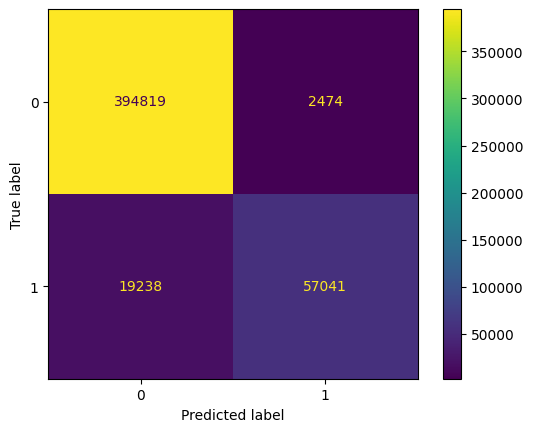

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, xgbprediction, labels=xgb_clf.classes_)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
disp.plot()
plt.show()

Getting false positive rows

In [ ]:
falseposdf = X_test[(y_test == 0) & (xgbprediction == 1)]
falseposdf

,UAS,Provider_ID,Provider_County_Code,CAPS_Zone,QR_Star,Tier,Gross_Paid,Adjust,Reg_Fee,Tier_bonus,Child_Fee,Net_Pay,Provd_Diff,Neg_Rate,Latency,Days_diff_1,Net_Gross_Diff,Child_PK_nunique,Case_nunique,FT_Rate_diff,BA_Rate_diff,max_uas,Max_Child_Age_UAS,Min_Child_Age_UAS,max_count_child_uas,max_child_toc,max_count_toc,License_Capacity,Difference_Capacity,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,Region_10,Region_11,Region_12,Region_14,TOP_Center,TOP_Family Home,TOC_Before & After School,TOC_Day Care,TOC_Night,TOC_Part Time,VSS_N,VSS_Y,binned_Zero,binned_0 to 1,binned_1 to 2,binned_3 to 5,binned_Above 6
562089,6,565,67.0,1,1.0,1,110.0,0.0,0.0,28.0,19.0,143,5.0,70.0,15,45.0,33.0,9.0,9.0,0.0,0.0,30,8,2,10,22,1,197,167,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
2089958,6,614,47.0,2,2.0,2,92.0,0.0,65.0,32.0,8.0,202,13.0,92.0,8,910.0,110.0,0.0,0.0,0.0,0.0,10,12,4,5,4,1,39,29,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
2519604,6,2410,75.0,1,1.0,0,65.0,0.0,0.0,0.0,4.0,65,0.0,65.0,15,18.0,0.0,4.0,4.0,0.0,0.0,15,9,6,4,8,1,124,109,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
2632552,14,321,67.0,1,2.0,2,124.0,0.0,0.0,43.0,41.0,208,41.0,70.0,15,102.0,84.0,8.0,8.0,0.0,0.0,26,4,4,1,9,1,223,197,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
2789618,12,2638,126.0,2,9.0,9,88.0,0.0,0.0,13.0,15.0,148,47.0,88.0,8,31.0,60.0,1.0,1.0,35.0,33.0,4,3,2,2,4,1,6,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534635,10,1316,116.0,2,3.0,3,102.0,0.0,65.0,56.0,5.0,223,0.0,102.0,8,4.0,121.0,10.0,10.0,0.0,0.0,47,2,1,2,15,1,103,56,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
2564735,6,1053,159.0,3,1.0,1,85.0,0.0,65.0,21.0,34.0,171,0.0,85.0,8,287.0,86.0,0.0,0.0,0.0,0.0,10,10,1,5,4,1,68,58,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0
37547,12,299,31.0,1,1.0,1,144.0,0.0,0.0,36.0,14.0,191,11.0,144.0,8,53.0,47.0,-1.0,-1.0,0.0,0.0,74,12,0,22,33,1,74,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0
1955220,9,1805,33.0,1,2.0,2,137.0,0.0,0.0,36.0,34.0,306,133.0,137.0,29,-24.0,169.0,1.0,1.0,133.0,57.0,4,4,4,3,3,1,211,207,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
